In [1]:
import asyncio
import os
import pandas as pd
import numpy as np
from dotenv import load_dotenv
from alpaca.data.live import StockDataStream
from alpaca.trading.client import TradingClient
from alpaca.trading.requests import MarketOrderRequest
from alpaca.trading.enums import OrderSide, TimeInForce
from alpaca.data.enums import DataFeed
from alpaca.data.timeframe import TimeFrame
import matplotlib.pyplot as plt
from datetime import datetime
from alpaca.data.historical import StockHistoricalDataClient
from alpaca.data.requests import StockBarsRequest

# Load environment variables
load_dotenv()  # Load .env file

API_KEY = os.getenv("ALPACA_API_KEY")
API_SECRET = os.getenv("ALPACA_SECRET_KEY")

# Initialize TradingClient
Trading_Client = TradingClient(API_KEY, API_SECRET, paper=True)  # paper=True for paper trading
data_client = StockHistoricalDataClient(API_KEY, API_SECRET)

Fetching 1-minute historical data for MSFT...
Running backtest...

--- Trade Summary ---
Total Trades: 233
Winning %: 50.21%
Total PnL: $67.03
Average PnL: $0.29


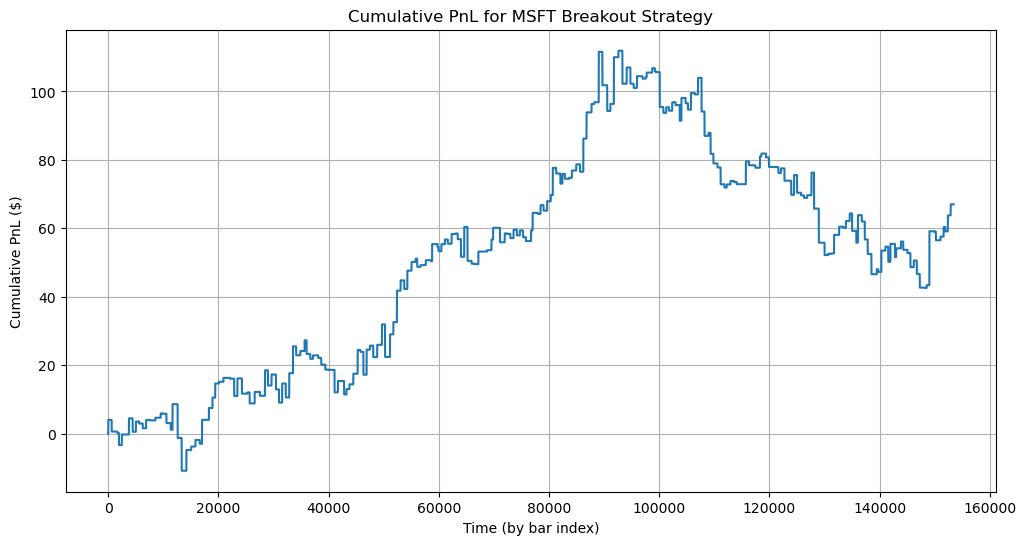

In [2]:
# --- Parameters ---
THRESHOLD = 0.7  # % move from open to trigger trade
STOP_LOSS_PCT = 2.4  # % stop loss
TAKE_PROFIT_PCT = 3.5  # % take profit
SYMBOL = "MSFT"
COMMISSION_PER_TRADE = 0  # Set to 0 if not considering costs for this version

# --- Fetch historical data ---
# Fetches minute-level data required for this intraday strategy
print(f"Fetching 1-minute historical data for {SYMBOL}...")
request_params = StockBarsRequest(
    symbol_or_symbols=[SYMBOL],
    timeframe=TimeFrame.Minute,
    start=datetime(2024, 1, 1),
    end=datetime(2024, 12, 31),
    adjustment='all'
)
bars = data_client.get_stock_bars(request_params)

# --- Handle DataFrame based on index type ---
df = bars.df
if isinstance(df.index, pd.MultiIndex):
    df = df.xs(SYMBOL, level='symbol').reset_index()
else:
    df = df.reset_index()

# --- Implement threshold strategy ---
def threshold_strategy(data, threshold, stop_loss_pct, take_profit_pct):
    data = data.copy()
    data['date'] = pd.to_datetime(data['timestamp']).dt.date
    data['Position'] = "None"
    data['PnL'] = 0.0

    # FIX: Initialize the list that will be returned
    trades_list = []

    grouped = data.groupby('date')

    for date, group in grouped:
        if group.empty:
            continue

        day_open = group.iloc[0]['open']
        threshold_up = day_open * (1 + threshold / 100)
        threshold_down = day_open * (1 - threshold / 100)

        trade_triggered = False

        for i in range(len(group)):
            current = group.iloc[i]
            idx = current.name # Use .name to get the index label safely

            # --- Long Entry ---
            if not trade_triggered and current['high'] >= threshold_up:
                entry_price = threshold_up
                data.loc[idx, 'Position'] = 'Long'
                trade_triggered = True

                sl_long = entry_price * (1 - stop_loss_pct / 100)
                tp_long = entry_price * (1 + take_profit_pct / 100)
                exit_price = 0
                pnl = 0

                for j in range(i + 1, len(group)):
                    forward = group.iloc[j]
                    if forward['low'] <= sl_long:
                        exit_price = sl_long
                        break
                    elif forward['high'] >= tp_long:
                        exit_price = tp_long
                        break
                else:
                    exit_price = group.iloc[-1]['close']

                pnl = (exit_price - entry_price) - COMMISSION_PER_TRADE
                data.loc[idx, 'PnL'] = pnl
                trades_list.append({'Date': date, 'Entry': entry_price, 'Exit': exit_price, 'PnL': pnl, 'Position': 'Long'})
                break

            # --- Short Entry ---
            elif not trade_triggered and current['low'] <= threshold_down:
                entry_price = threshold_down
                data.loc[idx, 'Position'] = 'Short'
                trade_triggered = True

                sl_short = entry_price * (1 + stop_loss_pct / 100)
                tp_short = entry_price * (1 - take_profit_pct / 100)
                exit_price = 0
                pnl = 0

                for j in range(i + 1, len(group)):
                    forward = group.iloc[j]
                    if forward['high'] >= sl_short:
                        exit_price = sl_short
                        break
                    elif forward['low'] <= tp_short:
                        exit_price = tp_short
                        break
                else:
                    exit_price = group.iloc[-1]['close']

                pnl = (entry_price - exit_price) - COMMISSION_PER_TRADE
                data.loc[idx, 'PnL'] = pnl
                trades_list.append({'Date': date, 'Entry': entry_price, 'Exit': exit_price, 'PnL': pnl, 'Position': 'Short'})
                break

    # FIX: Return both the DataFrame and the list of trades
    return data, trades_list


# --- Run strategy ---
print("Running backtest...")
results_df, trades = threshold_strategy(df, THRESHOLD, STOP_LOSS_PCT, TAKE_PROFIT_PCT)


# --- Metrics and Visualization ---
print("\n--- Trade Summary ---")
trades_df = pd.DataFrame(trades)
# Calculate cumulative PnL on the main results dataframe
results_df['Cumulative_PnL'] = results_df['PnL'].cumsum()

if not trades_df.empty:
    print(f"Total Trades: {len(trades_df)}")
    winning_trades = (trades_df['PnL'] > 0).sum()
    win_rate = (winning_trades / len(trades_df)) * 100 if len(trades_df) > 0 else 0
    print(f"Winning %: {win_rate:.2f}%")
    # Note: PnL here is the raw price change. To get $, you'd multiply by number of shares.
    print(f"Total PnL: ${trades_df['PnL'].sum():.2f}")
    print(f"Average PnL: ${trades_df['PnL'].mean():.2f}")

    # --- Plot ---
    plt.figure(figsize=(12, 6))
    # Plot from the main dataframe to show account growth over time
    results_df['Cumulative_PnL'].plot(title=f'Cumulative PnL for {SYMBOL} Breakout Strategy')
    plt.xlabel("Time (by bar index)")
    plt.ylabel("Cumulative PnL ($)")
    plt.grid(True)
    plt.show()
else:
    print("No trades were executed during the backtest period.")

*********************************************************

## Adding ATR dynamic thresholds

Fetching 1-minute historical data for MSFT...
Running ATR-based backtest...

--- Trade Summary ---
Total Trades: 121
Winning %: 53.72%
Total PnL: $28.51
Average PnL: $0.24


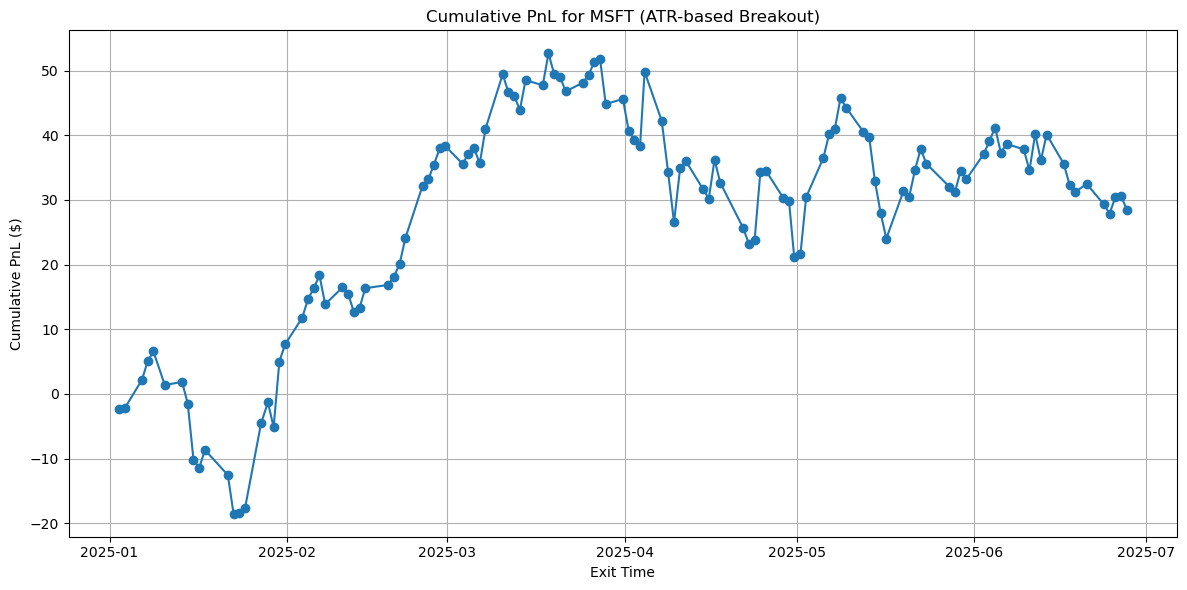

In [5]:
# --- Parameters ---
STOP_LOSS_PCT = 2.2  # % stop loss
TAKE_PROFIT_PCT = 3.1  # % take profit
SYMBOL = "MSFT"
COMMISSION_PER_TRADE = 0  # Set to 0 if not considering costs for this version

# --- Fetch historical data ---
print(f"Fetching 1-minute historical data for {SYMBOL}...")
request_params = StockBarsRequest(
    symbol_or_symbols=[SYMBOL],
    timeframe=TimeFrame.Minute,
    start=datetime(2025, 1, 1),
    end=datetime(2025, 6, 30),
    adjustment='all'
)
bars = data_client.get_stock_bars(request_params)

# --- Handle DataFrame based on index type ---
df = bars.df
if isinstance(df.index, pd.MultiIndex):
    df = df.xs(SYMBOL, level='symbol').reset_index()
else:
    df = df.reset_index()

# --- Calculate ATR on minute-level data grouped by day ---
df['date'] = pd.to_datetime(df['timestamp']).dt.date
df['H-L'] = df['high'] - df['low']
df['H-PC'] = abs(df['high'] - df['close'].shift(1))
df['L-PC'] = abs(df['low'] - df['close'].shift(1))
df['TR'] = df[['H-L', 'H-PC', 'L-PC']].max(axis=1)
df['ATR'] = df.groupby('date')['TR'].transform(lambda x: x.rolling(14, min_periods=1).mean())

# --- Implement ATR-based threshold strategy ---
def atr_threshold_strategy(data, stop_loss_pct, take_profit_pct):
    data = data.copy()
    data['Position'] = "None"
    data['PnL'] = 0.0

    trades_list = []

    grouped = data.groupby('date')

    for date, group in grouped:
        if group.empty:
            continue

        # Optional: skip first 15 minutes and last 5
        group = group.set_index('timestamp')
        group = group.between_time('09:45', '15:55').reset_index()
        if group.empty:
            continue

        day_open = group.iloc[0]['open']
        atr_val = group.iloc[0]['ATR']

        threshold_up = day_open + atr_val
        threshold_down = day_open - atr_val

        trade_triggered = False

        for i in range(len(group)):
            current = group.iloc[i]
            idx = current.name

            # --- Long Entry ---
            if not trade_triggered and current['high'] >= threshold_up:
                entry_price = threshold_up
                entry_time = current['timestamp']
                data.loc[idx, 'Position'] = 'Long'
                trade_triggered = True

                sl_long = entry_price * (1 - stop_loss_pct / 100)
                tp_long = entry_price * (1 + take_profit_pct / 100)

                for j in range(i + 1, len(group)):
                    forward = group.iloc[j]
                    if forward['low'] <= sl_long:
                        exit_price = sl_long
                        exit_time = forward['timestamp']
                        break
                    elif forward['high'] >= tp_long:
                        exit_price = tp_long
                        exit_time = forward['timestamp']
                        break
                else:
                    exit_price = group.iloc[-1]['close']
                    exit_time = group.iloc[-1]['timestamp']

                pnl = (exit_price - entry_price) - COMMISSION_PER_TRADE
                data.loc[idx, 'PnL'] = pnl
                trades_list.append({
                    'Date': date,
                    'Entry': entry_price,
                    'Exit': exit_price,
                    'PnL': pnl,
                    'Position': 'Long',
                    'EntryTime': entry_time,
                    'ExitTime': exit_time
                })
                break

            # --- Short Entry ---
            elif not trade_triggered and current['low'] <= threshold_down:
                entry_price = threshold_down
                entry_time = current['timestamp']
                data.loc[idx, 'Position'] = 'Short'
                trade_triggered = True

                sl_short = entry_price * (1 + stop_loss_pct / 100)
                tp_short = entry_price * (1 - take_profit_pct / 100)

                for j in range(i + 1, len(group)):
                    forward = group.iloc[j]
                    if forward['high'] >= sl_short:
                        exit_price = sl_short
                        exit_time = forward['timestamp']
                        break
                    elif forward['low'] <= tp_short:
                        exit_price = tp_short
                        exit_time = forward['timestamp']
                        break
                else:
                    exit_price = group.iloc[-1]['close']
                    exit_time = group.iloc[-1]['timestamp']

                pnl = (entry_price - exit_price) - COMMISSION_PER_TRADE
                data.loc[idx, 'PnL'] = pnl
                trades_list.append({
                    'Date': date,
                    'Entry': entry_price,
                    'Exit': exit_price,
                    'PnL': pnl,
                    'Position': 'Short',
                    'EntryTime': entry_time,
                    'ExitTime': exit_time
                })
                break

    data['Cumulative_PnL'] = data['PnL'].cumsum()
    return data, trades_list

# --- Run strategy ---
print("Running ATR-based backtest...")
results_df, trades = atr_threshold_strategy(df, STOP_LOSS_PCT, TAKE_PROFIT_PCT)

# --- Metrics and Visualization ---
print("\n--- Trade Summary ---")
trades_df = pd.DataFrame(trades)

if not trades_df.empty:
    print(f"Total Trades: {len(trades_df)}")
    winning_trades = (trades_df['PnL'] > 0).sum()
    win_rate = (winning_trades / len(trades_df)) * 100
    print(f"Winning %: {win_rate:.2f}%")
    print(f"Total PnL: ${trades_df['PnL'].sum():.2f}")
    print(f"Average PnL: ${trades_df['PnL'].mean():.2f}")

    # --- Plot cumulative PnL by trade exit time ---
    trades_df['ExitTime'] = pd.to_datetime(trades_df['ExitTime'])
    trades_df = trades_df.sort_values('ExitTime')
    trades_df['Cumulative_PnL'] = trades_df['PnL'].cumsum()

    plt.figure(figsize=(12, 6))
    plt.plot(trades_df['ExitTime'], trades_df['Cumulative_PnL'], marker='o')
    plt.title(f'Cumulative PnL for {SYMBOL} (ATR-based Breakout)')
    plt.xlabel("Exit Time")
    plt.ylabel("Cumulative PnL ($)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("No trades were executed during the backtest period.")

****************************************************

## Added trend-adjusted risk-based position sizing

Fetching 1-minute historical data for MSFT...
Running strategy...

--- Trade Summary ---
Total Trades: 251
Winning %: 57.77%
Total PnL: $316.23
Average PnL: $1.26


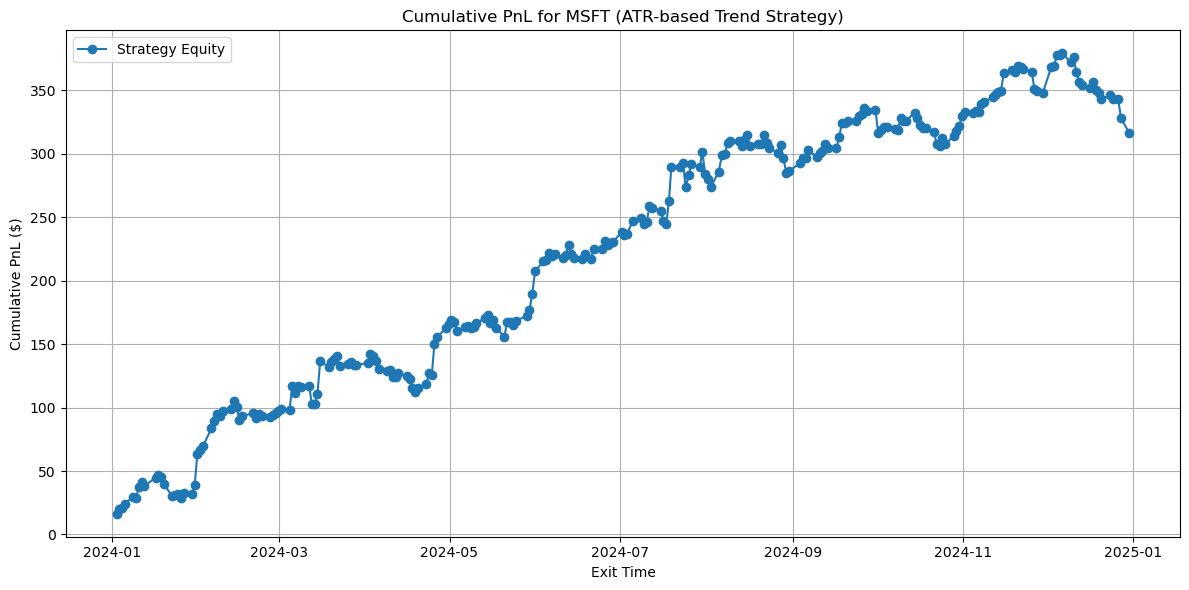

In [8]:
# --- Parameters ---
STOP_LOSS_PCT = 2.2  # % stop loss
TAKE_PROFIT_PCT = 3.1  # % take profit
SYMBOL = "MSFT"
COMMISSION_PER_TRADE = 0  # Set to 0 if not considering costs for this version

# --- Fetch historical data ---
print(f"Fetching 1-minute historical data for {SYMBOL}...")
request_params = StockBarsRequest(
    symbol_or_symbols=[SYMBOL],
    timeframe=TimeFrame.Minute,
    start=datetime(2024, 1, 1),
    end=datetime(2024, 12, 31),
    adjustment='all'
)
bars = data_client.get_stock_bars(request_params)

# --- Handle DataFrame based on index type ---
df = bars.df
if isinstance(df.index, pd.MultiIndex):
    df = df.xs(SYMBOL, level='symbol').reset_index()
else:
    df = df.reset_index()

# --- Preprocessing ---
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['date'] = df['timestamp'].dt.date
df['H-L'] = df['high'] - df['low']
df['H-PC'] = abs(df['high'] - df['close'].shift(1))
df['L-PC'] = abs(df['low'] - df['close'].shift(1))
df['TR'] = df[['H-L', 'H-PC', 'L-PC']].max(axis=1)
df['ATR'] = df.groupby('date')['TR'].transform(lambda x: x.rolling(14, min_periods=1).mean())

# --- Trend Detection Function ---
def detect_trend(group, window=30):
    if len(group) < window:
        return "neutral"
    moving_avg = group['close'].rolling(window=window).mean().iloc[-1]
    last_close = group['close'].iloc[-1]
    return "up" if last_close > moving_avg else "down"

# --- Position Sizing Function ---
def get_position_size(trend):
    if trend == "up":
        return {"long": 2, "short": 1}
    elif trend == "down":
        return {"long": 1, "short": 2}
    else:
        return {"long": 1, "short": 1}

# --- Strategy Implementation ---
def atr_threshold_strategy_with_trend(data, stop_loss_pct, take_profit_pct):
    data = data.copy()
    data['Position'] = "None"
    data['PnL'] = 0.0
    trades_list = []

    grouped = data.groupby('date')

    for date, group in grouped:
        if group.empty:
            continue

        group = group.copy()
        group['timestamp'] = pd.to_datetime(group['timestamp'])
        group = group.set_index('timestamp')
        group = group.between_time('09:45', '15:55')
        if group.empty:
            continue

        group = group.reset_index()
        atr_val = group['ATR'].dropna().iloc[0] if not group['ATR'].dropna().empty else None
        if atr_val is None:
            continue

        day_open = group.iloc[0]['open']
        threshold_up = day_open + atr_val
        threshold_down = day_open - atr_val

        trend = detect_trend(group, window=30)
        size_map = get_position_size(trend)

        trade_triggered = False

        for i in range(len(group)):
            current = group.iloc[i]
            idx = current.name

            # --- Long Entry ---
            if not trade_triggered and current['high'] >= threshold_up:
                entry_price = threshold_up
                entry_time = current['timestamp']
                shares = size_map['long']
                data.loc[idx, 'Position'] = f'Long ({shares})'
                trade_triggered = True

                sl_long = entry_price * (1 - stop_loss_pct / 100)
                tp_long = entry_price * (1 + take_profit_pct / 100)

                for j in range(i + 1, len(group)):
                    forward = group.iloc[j]
                    if forward['low'] <= sl_long:
                        exit_price = sl_long
                        exit_time = forward['timestamp']
                        break
                    elif forward['high'] >= tp_long:
                        exit_price = tp_long
                        exit_time = forward['timestamp']
                        break
                else:
                    exit_price = group.iloc[-1]['close']
                    exit_time = group.iloc[-1]['timestamp']

                pnl = (exit_price - entry_price) * shares - COMMISSION_PER_TRADE
                data.loc[idx, 'PnL'] = pnl
                trades_list.append({
                    'Date': date,
                    'Entry': entry_price,
                    'Exit': exit_price,
                    'PnL': pnl,
                    'Position': 'Long',
                    'Shares': shares,
                    'Trend': trend,
                    'EntryTime': entry_time,
                    'ExitTime': exit_time
                })
                break

            # --- Short Entry ---
            elif not trade_triggered and current['low'] <= threshold_down:
                entry_price = threshold_down
                entry_time = current['timestamp']
                shares = size_map['short']
                data.loc[idx, 'Position'] = f'Short ({shares})'
                trade_triggered = True

                sl_short = entry_price * (1 + stop_loss_pct / 100)
                tp_short = entry_price * (1 - take_profit_pct / 100)

                for j in range(i + 1, len(group)):
                    forward = group.iloc[j]
                    if forward['high'] >= sl_short:
                        exit_price = sl_short
                        exit_time = forward['timestamp']
                        break
                    elif forward['low'] <= tp_short:
                        exit_price = tp_short
                        exit_time = forward['timestamp']
                        break
                else:
                    exit_price = group.iloc[-1]['close']
                    exit_time = group.iloc[-1]['timestamp']

                pnl = (entry_price - exit_price) * shares - COMMISSION_PER_TRADE
                data.loc[idx, 'PnL'] = pnl
                trades_list.append({
                    'Date': date,
                    'Entry': entry_price,
                    'Exit': exit_price,
                    'PnL': pnl,
                    'Position': 'Short',
                    'Shares': shares,
                    'Trend': trend,
                    'EntryTime': entry_time,
                    'ExitTime': exit_time
                })
                break

    data['Cumulative_PnL'] = data['PnL'].cumsum()
    return data, trades_list

# --- Run Backtest ---
print("Running strategy...")
results_df, trades = atr_threshold_strategy_with_trend(df, STOP_LOSS_PCT, TAKE_PROFIT_PCT)

# --- Metrics & Plot ---
print("\n--- Trade Summary ---")
trades_df = pd.DataFrame(trades)

if not trades_df.empty:
    trades_df['ExitTime'] = pd.to_datetime(trades_df['ExitTime'])
    trades_df = trades_df.sort_values('ExitTime')
    trades_df['Cumulative_PnL'] = trades_df['PnL'].cumsum()

    print(f"Total Trades: {len(trades_df)}")
    win_rate = (trades_df['PnL'] > 0).mean() * 100
    print(f"Winning %: {win_rate:.2f}%")
    print(f"Total PnL: ${trades_df['PnL'].sum():.2f}")
    print(f"Average PnL: ${trades_df['PnL'].mean():.2f}")

    plt.figure(figsize=(12, 6))
    plt.plot(trades_df['ExitTime'], trades_df['Cumulative_PnL'], marker='o', label='Strategy Equity')
    plt.title(f'Cumulative PnL for {SYMBOL} (ATR-based Trend Strategy)')
    plt.xlabel("Exit Time")
    plt.ylabel("Cumulative PnL ($)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("No trades were executed during the backtest period.")

**********************************

## ATR adjustment for accuracy and volume confirmation

Fetching 1-minute historical data for MSFT...
Running strategy...

--- Trade Summary ---
Total Trades: 121
Winning %: 59.50%
Total PnL: $192.24
Average PnL: $1.59


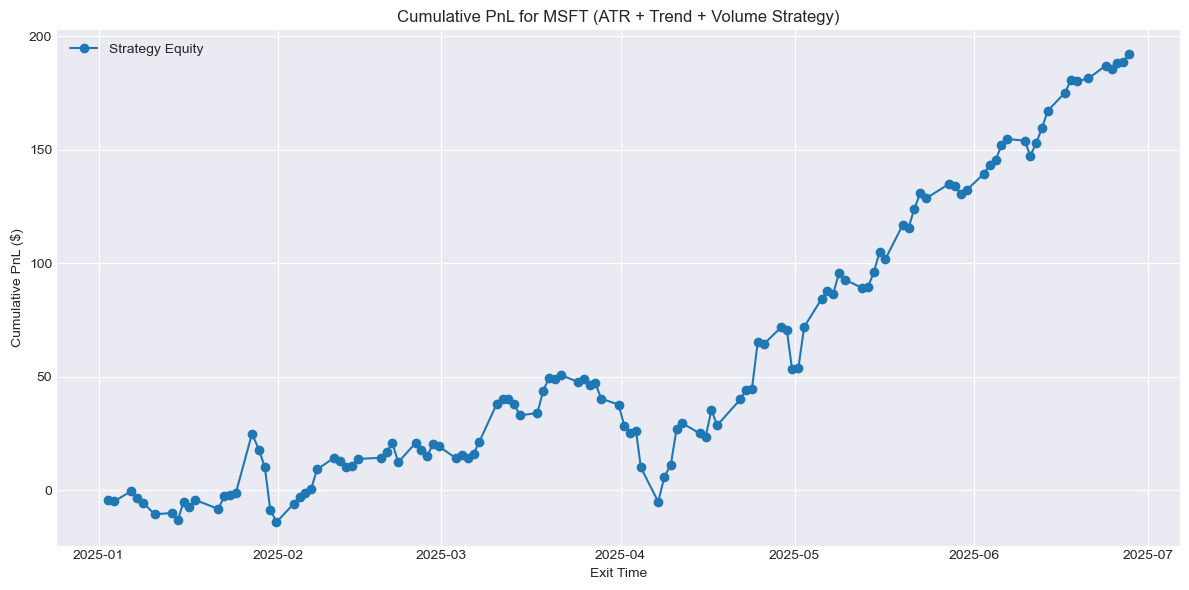

In [25]:
# --- Parameters ---
STOP_LOSS_PCT = 2.2
TAKE_PROFIT_PCT = 3.1
SYMBOL = "MSFT"
COMMISSION_PER_TRADE = 0

# --- Alpaca Data Client (insert your credentials here) ---
data_client = StockHistoricalDataClient(API_KEY, API_SECRET)

# --- Fetch historical data ---
print(f"Fetching 1-minute historical data for {SYMBOL}...")
request_params = StockBarsRequest(
    symbol_or_symbols=[SYMBOL],
    timeframe=TimeFrame.Minute,
    start=datetime(2025, 1, 1),
    end=datetime(2025, 6, 29),
    adjustment='all'
)
bars = data_client.get_stock_bars(request_params)

# --- Handle DataFrame based on index type ---
df = bars.df
if isinstance(df.index, pd.MultiIndex):
    df = df.xs(SYMBOL, level='symbol').reset_index()
else:
    df = df.reset_index()

# --- Preprocessing ---
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['date'] = df['timestamp'].dt.date
df['H-L'] = df['high'] - df['low']
df['H-PC'] = abs(df['high'] - df['close'].shift(1))
df['L-PC'] = abs(df['low'] - df['close'].shift(1))
df['TR'] = df[['H-L', 'H-PC', 'L-PC']].max(axis=1)

# --- Corrected ATR (no lookahead bias) ---
df['Rolling_ATR'] = (
    df.groupby('date')['TR']
    .transform(lambda x: x.rolling(14, min_periods=1).mean())
)

df['ATR'] = (
    df.groupby('date')['Rolling_ATR']
    .transform('last')
    .shift()
)

# --- Trend Detection ---
def detect_trend(group, window=30):
    if len(group) < window:
        return "neutral"
    ma = group['close'].rolling(window=window).mean().iloc[-1]
    last = group['close'].iloc[-1]
    return "up" if last > ma else "down"

# --- Trend-based Position Sizing ---
def get_position_size(trend):
    if trend == "up":
        return {"long": 2, "short": 1}
    elif trend == "down":
        return {"long": 1, "short": 2}
    else:
        return {"long": 1, "short": 1}

# --- Strategy with ATR & Volume Confirmation ---
def atr_threshold_strategy_with_trend_and_volume(data, stop_loss_pct, take_profit_pct):
    data = data.copy()
    data['Position'] = "None"
    data['PnL'] = 0.0
    trades_list = []

    grouped = data.groupby('date')

    for date, group in grouped:
        if group.empty:
            continue

        group = group.copy()
        group['timestamp'] = pd.to_datetime(group['timestamp'])
        group = group.set_index('timestamp')
        group = group.between_time('09:45', '15:55')

        if group.empty:
            continue

        group = group.reset_index()

        # ATR check
        atr_val = group['ATR'].dropna().iloc[0] if not group['ATR'].dropna().empty else None
        if atr_val is None or atr_val < 0.01:
            continue

        # Thresholds based on previous ATR
        day_open = group.iloc[0]['open']
        threshold_up = day_open + atr_val
        threshold_down = day_open - atr_val

        # Volume threshold (75th percentile of the day)
        volume_threshold = group['volume'].quantile(0.75)

        trend = detect_trend(group, window=30)
        size_map = get_position_size(trend)
        trade_triggered = False

        for i in range(len(group)):
            current = group.iloc[i]
            idx = current.name

            # --- Long Entry ---
            if not trade_triggered and current['high'] >= threshold_up and current['volume'] >= volume_threshold:
                entry_price = threshold_up
                entry_time = current['timestamp']
                shares = size_map['long']
                data.loc[idx, 'Position'] = f'Long ({shares})'
                trade_triggered = True

                sl = entry_price * (1 - stop_loss_pct / 100)
                tp = entry_price * (1 + take_profit_pct / 100)

                for j in range(i + 1, len(group)):
                    fwd = group.iloc[j]
                    if fwd['low'] <= sl:
                        exit_price = sl
                        exit_time = fwd['timestamp']
                        break
                    elif fwd['high'] >= tp:
                        exit_price = tp
                        exit_time = fwd['timestamp']
                        break
                else:
                    exit_price = group.iloc[-1]['close']
                    exit_time = group.iloc[-1]['timestamp']

                pnl = (exit_price - entry_price) * shares - COMMISSION_PER_TRADE
                data.loc[idx, 'PnL'] = pnl
                trades_list.append({
                    'Date': date, 'Entry': entry_price, 'Exit': exit_price, 'PnL': pnl,
                    'Position': 'Long', 'Shares': shares, 'Trend': trend,
                    'EntryTime': entry_time, 'ExitTime': exit_time
                })
                break

            # --- Short Entry ---
            elif not trade_triggered and current['low'] <= threshold_down and current['volume'] >= volume_threshold:
                entry_price = threshold_down
                entry_time = current['timestamp']
                shares = size_map['short']
                data.loc[idx, 'Position'] = f'Short ({shares})'
                trade_triggered = True

                sl = entry_price * (1 + stop_loss_pct / 100)
                tp = entry_price * (1 - take_profit_pct / 100)

                for j in range(i + 1, len(group)):
                    fwd = group.iloc[j]
                    if fwd['high'] >= sl:
                        exit_price = sl
                        exit_time = fwd['timestamp']
                        break
                    elif fwd['low'] <= tp:
                        exit_price = tp
                        exit_time = fwd['timestamp']
                        break
                else:
                    exit_price = group.iloc[-1]['close']
                    exit_time = group.iloc[-1]['timestamp']

                pnl = (entry_price - exit_price) * shares - COMMISSION_PER_TRADE
                data.loc[idx, 'PnL'] = pnl
                trades_list.append({
                    'Date': date, 'Entry': entry_price, 'Exit': exit_price, 'PnL': pnl,
                    'Position': 'Short', 'Shares': shares, 'Trend': trend,
                    'EntryTime': entry_time, 'ExitTime': exit_time
                })
                break

    data['Cumulative_PnL'] = data['PnL'].cumsum()
    return data, trades_list

# --- Run Backtest ---
print("Running strategy...")
results_df, trades = atr_threshold_strategy_with_trend_and_volume(df, STOP_LOSS_PCT, TAKE_PROFIT_PCT)

# --- Metrics & Plot ---
print("\n--- Trade Summary ---")
trades_df = pd.DataFrame(trades)

if not trades_df.empty:
    trades_df['ExitTime'] = pd.to_datetime(trades_df['ExitTime'])
    trades_df = trades_df.sort_values('ExitTime')
    trades_df['Cumulative_PnL'] = trades_df['PnL'].cumsum()

    print(f"Total Trades: {len(trades_df)}")
    win_rate = (trades_df['PnL'] > 0).mean() * 100
    print(f"Winning %: {win_rate:.2f}%")
    print(f"Total PnL: ${trades_df['PnL'].sum():.2f}")
    print(f"Average PnL: ${trades_df['PnL'].mean():.2f}")

    # --- Plot PnL Curve ---
    plt.figure(figsize=(12, 6))
    plt.plot(trades_df['ExitTime'], trades_df['Cumulative_PnL'], marker='o', label='Strategy Equity')
    plt.title(f'Cumulative PnL for {SYMBOL} (ATR + Trend + Volume Strategy)')
    plt.xlabel("Exit Time")
    plt.ylabel("Cumulative PnL ($)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("No trades were executed during the backtest period.")


*****************************

## ML Model implementation

Fetching 1-minute historical data for MSFT...
Generating ML features...
Predicting ML signals...
Calculating daily trend...
Running corrected strategy...

--- Trade Summary ---
Total Trades: 1136
Winning %: 54.67%
Total PnL: $598.11
Average PnL: $0.53


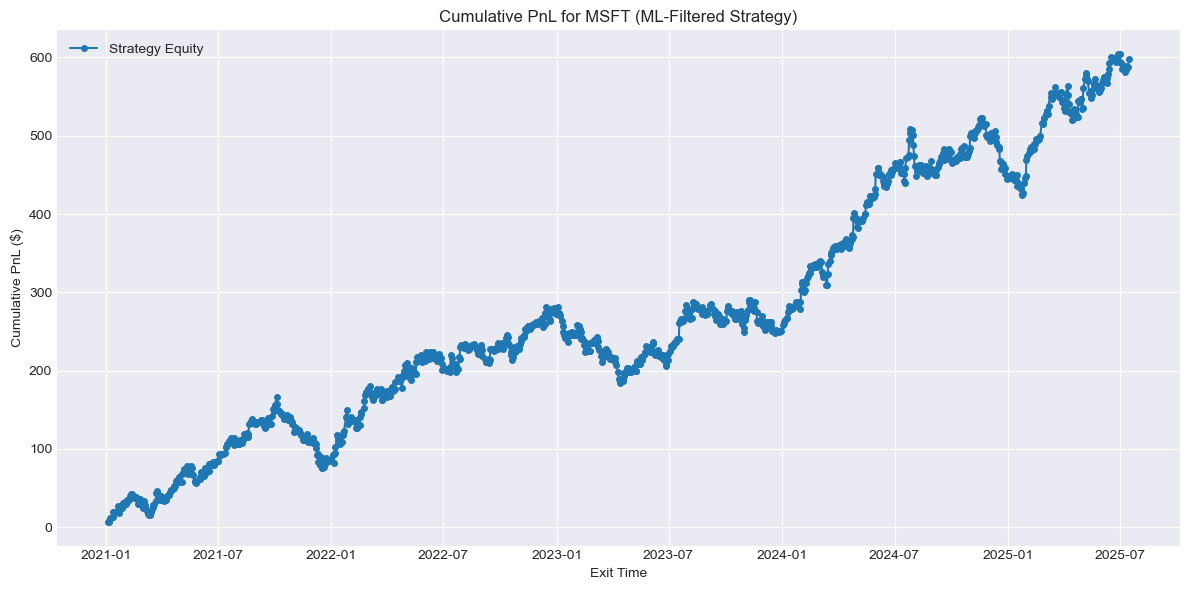

In [79]:
# === Imports ===
import joblib

# === Parameters ===
SYMBOL = "MSFT"
STOP_LOSS_PCT = 1.6
TAKE_PROFIT_PCT = 3.0
COMMISSION_PER_TRADE = 0
TREND_SMA_PERIOD = 20
VOLUME_AVG_PERIOD = 30
VOLUME_SPIKE_MULTIPLIER = 1.5
CUSTOM_THRESHOLD = 0.5  # ML threshold

# === Load ML Model and Features ===
ml_model = joblib.load("ml_model.pkl")
ml_features = joblib.load("features.pkl")

# === Alpaca Data Client ===
data_client = StockHistoricalDataClient(API_KEY, API_SECRET)

# === Fetch historical data ===
print(f"Fetching 1-minute historical data for {SYMBOL}...")
request_params = StockBarsRequest(
    symbol_or_symbols=[SYMBOL],
    timeframe=TimeFrame.Minute,
    start=datetime(2021, 1, 1),
    end=datetime(2025, 7, 16),
    adjustment='all'
)
bars = data_client.get_stock_bars(request_params)

df = bars.df
if isinstance(df.index, pd.MultiIndex):
    df = df.xs(SYMBOL, level='symbol').reset_index()
else:
    df = df.reset_index()

df['timestamp'] = pd.to_datetime(df['timestamp'])
df['date'] = df['timestamp'].dt.date

# === Feature Engineering for ML ===
print("Generating ML features...")
df['rsi'] = momentum.RSIIndicator(df['close'], window=14).rsi()
df['atr'] = volatility.AverageTrueRange(df['high'], df['low'], df['close'], window=14).average_true_range()
df['macd_diff'] = trend.MACD(df['close']).macd_diff()
df['vol_rolling'] = df['volume'].rolling(30).mean()
df['atr_ratio'] = df['atr'] / df['close']
df['daily_close'] = df.groupby('date')['close'].transform('last')
df['sma_trend'] = df['daily_close'].rolling(20).mean()
df['daily_trend'] = np.where(df['daily_close'] > df['sma_trend'], 'up', 'down')
df['trend_num'] = df['daily_trend'].map({'up': 1, 'down': -1})
df['returns'] = df['close'].pct_change()
df['volatility'] = df['returns'].rolling(20).std()
df['volume_spike'] = df['volume'] / df['volume'].rolling(20).mean()
df['sma_slope'] = df['sma_trend'].diff()

for lag in range(1, 4):
    df[f'rsi_lag{lag}'] = df['rsi'].shift(lag)
    df[f'macd_diff_lag{lag}'] = df['macd_diff'].shift(lag)

# === Predict ML Signals ===
print("Predicting ML signals...")
df_ml = df.dropna(subset=ml_features).copy()
X_pred = df_ml[ml_features]
df_ml['ml_signal'] = (ml_model.predict_proba(X_pred)[:, 1] > CUSTOM_THRESHOLD).astype(int)

# Merge predictions back
df = df.merge(df_ml[['timestamp', 'ml_signal']], on='timestamp', how='left')
df['ml_signal'] = df['ml_signal'].fillna(0).astype(int)

# === ATR Calculation (no lookahead) ===
df['H-L'] = df['high'] - df['low']
df['H-PC'] = abs(df['high'] - df['close'].shift(1))
df['L-PC'] = abs(df['low'] - df['close'].shift(1))
df['TR'] = df[['H-L', 'H-PC', 'L-PC']].max(axis=1)
df['Rolling_ATR'] = df.groupby('date')['TR'].transform(lambda x: x.rolling(14, min_periods=1).mean())
df['ATR'] = df.groupby('date')['Rolling_ATR'].transform('last').shift()

# === Trend Detection ===
print("Calculating daily trend...")
daily_df = df.groupby('date').agg(daily_close=('close', 'last')).reset_index()
daily_df['sma_trend'] = daily_df['daily_close'].rolling(window=TREND_SMA_PERIOD).mean()
daily_df['daily_trend'] = np.where(daily_df['daily_close'] > daily_df['sma_trend'], 'up', 'down')
daily_df['daily_trend'] = daily_df['daily_trend'].shift(1)
trend_map = daily_df.set_index('date')['daily_trend']
df['daily_trend'] = df['date'].map(trend_map)
df['daily_trend'] = df['daily_trend'].fillna("neutral")

# === Position Sizing ===
def get_position_size(trend):
    if trend == "up":
        return {"long": 2, "short": 1}
    elif trend == "down":
        return {"long": 1, "short": 2}
    else:
        return {"long": 1, "short": 1}

# === Strategy Function with ML Filter ===
def corrected_strategy(data, stop_loss_pct, take_profit_pct):
    data = data.copy()
    data['Position'] = "None"
    data['PnL'] = 0.0
    trades_list = []

    grouped = data.groupby('date')

    for date, group in grouped:
        if group.empty:
            continue

        group = group.copy()
        group = group.set_index('timestamp')
        group = group.between_time('09:45', '15:55')

        if group.empty:
            continue

        group['rolling_vol_avg'] = group['volume'].rolling(window=VOLUME_AVG_PERIOD, min_periods=1).mean().shift(1)
        group = group.reset_index()

        atr_val = group['ATR'].dropna().iloc[0] if not group['ATR'].dropna().empty else None
        if atr_val is None or atr_val < 0.01:
            continue

        day_open = group.iloc[0]['open']
        threshold_up = day_open + atr_val
        threshold_down = day_open - atr_val
        trend = group['daily_trend'].iloc[0]
        size_map = get_position_size(trend)
        trade_triggered = False

        for i in range(len(group)):
            current = group.iloc[i]
            idx = current.name

            if pd.isna(current['rolling_vol_avg']):
                continue

            volume_threshold = current['rolling_vol_avg'] * VOLUME_SPIKE_MULTIPLIER

            # --- Long Entry (With ML Filter) ---
            if (
                not trade_triggered and 
                current['ml_signal'] == 1 and 
                current['high'] >= threshold_up and 
                current['volume'] > volume_threshold
            ):
                entry_price = threshold_up
                entry_time = current['timestamp']
                shares = size_map['long']
                data.loc[idx, 'Position'] = f'Long ({shares})'
                trade_triggered = True

                sl = entry_price * (1 - stop_loss_pct / 100)
                tp = entry_price * (1 + take_profit_pct / 100)
                exit_price = group.iloc[-1]['close']
                exit_time = group.iloc[-1]['timestamp']

                for j in range(i + 1, len(group)):
                    fwd = group.iloc[j]
                    if fwd['low'] <= sl:
                        exit_price = sl
                        exit_time = fwd['timestamp']
                        break
                    elif fwd['high'] >= tp:
                        exit_price = tp
                        exit_time = fwd['timestamp']
                        break

                pnl = (exit_price - entry_price) * shares - COMMISSION_PER_TRADE
                data.loc[idx, 'PnL'] = pnl
                trades_list.append({
                    'Date': date, 'Entry': entry_price, 'Exit': exit_price, 'PnL': pnl,
                    'Position': 'Long', 'Shares': shares, 'Trend': trend,
                    'EntryTime': entry_time, 'ExitTime': exit_time
                })
                break

            # --- Short Entry (With ML Filter) ---
            elif (
                not trade_triggered and 
                current['ml_signal'] == 1 and 
                current['low'] <= threshold_down and 
                current['volume'] > volume_threshold
            ):
                entry_price = threshold_down
                entry_time = current['timestamp']
                shares = size_map['short']
                data.loc[idx, 'Position'] = f'Short ({shares})'
                trade_triggered = True

                sl = entry_price * (1 + stop_loss_pct / 100)
                tp = entry_price * (1 - take_profit_pct / 100)
                exit_price = group.iloc[-1]['close']
                exit_time = group.iloc[-1]['timestamp']

                for j in range(i + 1, len(group)):
                    fwd = group.iloc[j]
                    if fwd['high'] >= sl:
                        exit_price = sl
                        exit_time = fwd['timestamp']
                        break
                    elif fwd['low'] <= tp:
                        exit_price = tp
                        exit_time = fwd['timestamp']
                        break

                pnl = (entry_price - exit_price) * shares - COMMISSION_PER_TRADE
                data.loc[idx, 'PnL'] = pnl
                trades_list.append({
                    'Date': date, 'Entry': entry_price, 'Exit': exit_price, 'PnL': pnl,
                    'Position': 'Short', 'Shares': shares, 'Trend': trend,
                    'EntryTime': entry_time, 'ExitTime': exit_time
                })
                break

    data['Cumulative_PnL'] = data['PnL'].cumsum()
    return data, trades_list

# === Run Backtest ===
print("Running corrected strategy...")
results_df, trades = corrected_strategy(df, STOP_LOSS_PCT, TAKE_PROFIT_PCT)

# === Metrics and Plot ===
print("\n--- Trade Summary ---")
trades_df = pd.DataFrame(trades)

if not trades_df.empty:
    trades_df['ExitTime'] = pd.to_datetime(trades_df['ExitTime'])
    trades_df = trades_df.sort_values('ExitTime')
    trades_df['Cumulative_PnL'] = trades_df['PnL'].cumsum()

    print(f"Total Trades: {len(trades_df)}")
    win_rate = (trades_df['PnL'] > 0).mean() * 100
    print(f"Winning %: {win_rate:.2f}%")
    print(f"Total PnL: ${trades_df['PnL'].sum():.2f}")
    print(f"Average PnL: ${trades_df['PnL'].mean():.2f}")

    # === Plot PnL ===
    plt.style.use('seaborn-v0_8-darkgrid')
    plt.figure(figsize=(12, 6))
    plt.plot(trades_df['ExitTime'], trades_df['Cumulative_PnL'], marker='o', linestyle='-', markersize=4, label='Strategy Equity')
    plt.title(f'Cumulative PnL for {SYMBOL} (ML-Filtered Strategy)')
    plt.xlabel("Exit Time")
    plt.ylabel("Cumulative PnL ($)")
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("No trades were executed during the backtest period.")
